In [1]:
import glob
import re
import bs4
import cltk
import nltk

import numpy as np
from collections import defaultdict, Counter
from nltk.tokenize.punkt import PunktLanguageVars

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram   

from sklearn.feature_extraction.text import TfidfVectorizer
from cltk.stop.latin.stops import STOPS_LIST

import itertools

stop_words = STOPS_LIST.extend(['quod', 'vel', 'sunt', 'hoc', 'vero', 'sit', 'sol', 'que', 'esse'])

%matplotlib inline

In [2]:
from cltk.corpus.utils.importer import CorpusImporter

corpus_importer = CorpusImporter('latin')
corpus_importer.import_corpus('latin_text_latin_library')
corpus_importer.import_corpus('latin_pos_lemmata_cltk')
corpus_importer.import_corpus('latin_models_cltk')

INFO:CLTK:Pulling latest 'latin_text_latin_library' from 'https://github.com/cltk/latin_text_latin_library.git'.
INFO:CLTK:Pulling latest 'latin_pos_lemmata_cltk' from 'https://github.com/cltk/latin_pos_lemmata_cltk.git'.
INFO:CLTK:Pulling latest 'latin_models_cltk' from 'https://github.com/cltk/latin_models_cltk.git'.


In [3]:
# This corpus comes from the Thesaurus Musicarum Latinarum.

corpus_files = glob.glob('corpus/html/*.html')

In [4]:
soups = [bs4.BeautifulSoup(open(file), 'lxml') for file in corpus_files]

In [5]:
def process_soup(soup):
    "Takes a bs4 BeautifulSoup object and returns a dict with document content and metadata."
    corpus_item = {}
    
    header = soup.find('p')

    original = " ".join([n for n in soup.findAll(text=True)])
    
    body = "".join([p.text for p in soup.findAll('p')[1:]])
    body = remove_newlines(body)
    body = remove_doublespace(body)
    body = remove_editorial_apparatus(body)
    body = join_hyphens(body)
    
    century_re = re.compile('.*www.chmtl.indiana.edu\/tml\/(\w+\W*\w+)\/.*')
    
    try:
        comments = "".join(soup.findAll(text=lambda text:isinstance(text, bs4.Comment)))
        century = century_re.match(comments).groups()[0]
        corpus_item['century'] = century
    except:
        corpus_item['century'] = 'nd'

    corpus_item['body'] = body.strip()
    corpus_item['id'] = soup.title.text.split(' ')[0]
    
    match = re.search(r"Author:\s(.*)", original)
    
    if match:
        result = match.group(1)
    else:
        result = ""
    
    corpus_item['author'] = result
    
    match = re.search(r"Title:\s(.*)", original)
    
    if match:
        result = match.group(1)
    else:
        result = ""
        
    corpus_item['title'] = result
    
    return corpus_item

def remove_editorial_apparatus(text):
    "Removes all text enclosed in square brackets."
    pattern = re.compile('\[.+?\]')
    return pattern.sub('', text)

def remove_newlines(text):
    "Replaces newlines with spaces."
    return text.replace('\n', ' ')

def remove_doublespace(text):
    "Removes any doublespaces."
    return text.replace('  ', ' ')

def join_hyphens(text):
    "Joins hyphens used at ends of lines."
    return text.replace('-\n', '')

def my_tokenize(document):
    "Tokenizes a document, represented as a string using Punkt."
    p = PunktLanguageVars()
    tokens = p.word_tokenize(document)
    tokens = [x.lower() for x in tokens if x not in (',', ';', '.', "'", '"',':',')','(', '|' , '||' )]
    return tokens

In [6]:
corpus = []

for soup in soups:
    try:
        corpus_item = process_soup(soup)
    except:
        continue
        
    corpus.append(corpus_item)

In [7]:
len(corpus)

807

In [8]:
def prepare_id_info_map(corpus):
    id_info_map = {}
    for item in corpus:
        info = {
            'author' : item['author'],
            'title' : item['title'],
            'id' : item['id'],
            'century': item['century'],
            'length' : len(my_tokenize(item['body']))
        }
        id_info_map[item['id']] = info
    return id_info_map

In [9]:
id_info_map = prepare_id_info_map(corpus)

In [10]:
id_info_map['AARIH1']

{'author': 'Aaron, Petrus',
 'century': '16th',
 'id': 'AARIH1',
 'length': 10496,
 'title': 'De institutione harmonica, liber primus'}

In [11]:
def filter_stopwords(tokens):
    "Filters stopwords from list of tokens."
    return [token for token in tokens if token not in STOPS_LIST]

def filter_shortwords(tokens, short_size=2):
    "Filters tokens of size greater than short_size from list of tokens."
    return [token for token in tokens if len(token) > short_size]

In [12]:
from cltk.stem.lemma import LemmaReplacer

lemmatizer = LemmaReplacer('latin')

In [13]:
def prep(document):
    "A convenience function which applies a series of operations to a document represented in a string."
    tokenized = my_tokenize(document)
    stopped = filter_stopwords(tokenized)
    shorted = filter_shortwords(stopped)
    lemmatized = lemmatizer.lemmatize(shorted)
    done = lemmatized
    return done

In [14]:
# This is some code to restrict sample to a certain set of parameters
# TODO: Make a proper query interface for corpus entries

q_century = '13th'
q_min_size = 500
q_max_size = 10000000

sample = [treatise for treatise in corpus\
          if treatise['century'] == q_century\
          and len(treatise['body']) < q_max_size\
          and len(treatise['body']) > q_min_size]

bodys = [treatise['body'] for treatise in sample]
ids = [treatise['id'] for treatise in sample]
titles = [treatise.get('title', 'nt')[:15] for treatise in sample]
authors = [treatise.get('author', 'na')[:15] for treatise in sample]

len(sample) , len(ids), len(titles)

(79, 79, 79)

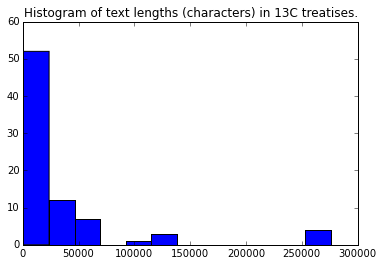

In [15]:
lengths = [len(treatise['body']) for treatise in sample]
plt.hist(lengths, bins=12)
plt.title('Histogram of text lengths (characters) in 13C treatises.')
plt.show()

## Text Similarity - Ward clustering in tf-idf space

In [31]:
documents = [doc['body'] for doc in corpus]

tfidf = TfidfVectorizer(tokenizer=prep, stop_words=stop_words)
tfs = tfidf.fit_transform(documents)

In [32]:
tfs = tfidf.transform(bodys)
tfs.shape

dist = 1 - cosine_similarity(tfs)

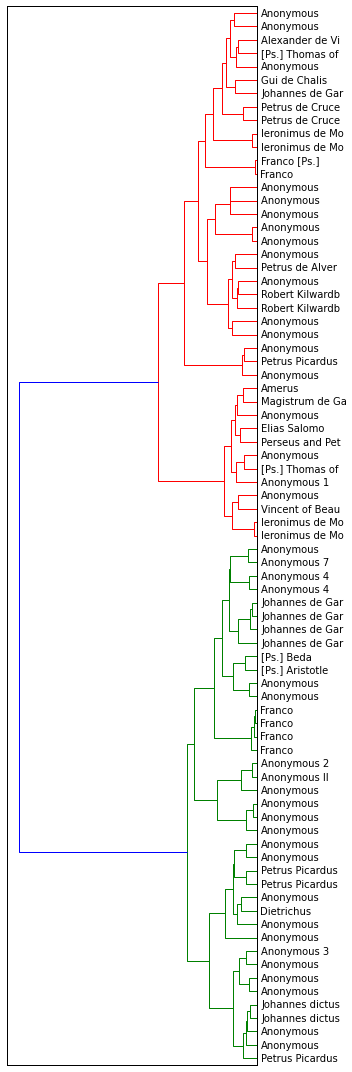

In [33]:
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(5, 15)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=authors);

plt.tick_params(axis='x',          
    which='both',      
    bottom='off',      
    top='off',         
    labelbottom='off')

plt.tight_layout() 

## Text reuse - Study B 

Reimplementation of the Viral Texts methodology

Part I. Identify document pair candidates

1. Pick out a subset of all the texts for testing purposes
2. ~~Make a hashmap id -> tokenized text~~
3. Make a hashmap id -> shingled text
4. For each n-gram, create a list of (d_i, p_i) - document ID and position ID
5. Exclude singleton n-grams
6. Extract candidate pairs
7. Filter (e.g. suppress n-grams that generate more than some fixed number of pairs)
8. Rank

Part II. Local document alignment

1. Do Smith-Waterman 

In [34]:
import random

N = 5

def zipngram(document_tokens,n=N):
    return zip(*[document_tokens[i:] for i in range(n)])

In [17]:
def prepare_ngram_index(id_shingled_map):
    ngram_index = defaultdict(list)
    
    for _id, shingled_rep in id_shingled_map.items():
        for position, n_gram in enumerate(shingled_rep):
            ngram_index[n_gram].append((_id, position))
    
    return ngram_index

def filter_singletons(ngram_index):
    # Naive implementation not advised in article
    # TODO: Implement nice two-pass hash fxn. method
    filtered_ngram_index = {}
    
    for ngram, locations in ngram_index.items():
        if len(locations) > 1:
            filtered_ngram_index[ngram] = locations
    
    return filtered_ngram_index

def prepare_id_tokenized_map(corpus):
    id_tokenized_map = {}
    
    for text in corpus:
        id_tokenized_map[text['id']] = my_tokenize(text['body'])
        
    return id_tokenized_map
            
def prepare_id_shingled_map(corpus): 
    id_shingled_map = {}
    
    for text in corpus:
        tokenized_body = my_tokenize(text['body'])
        id_shingled_map[text['id']] = zipngram(tokenized_body, N)
    
    return id_shingled_map

def prepare_pair_ngrams_map(ngram_index):
    pair_ngrams_map = defaultdict(list)
    
    for ngram, locations in ngram_index.items():
        documents = list(set([location[0] for location in locations]))
        for p in itertools.combinations(documents, 2):
            pair_ngrams_map[p].append(ngram)
    
    return pair_ngrams_map

In [18]:
subset = corpus

In [19]:
%time id_tokenized_map = prepare_id_tokenized_map(subset)

CPU times: user 14.4 s, sys: 291 ms, total: 14.7 s
Wall time: 15.1 s


In [20]:
%time id_shingled_map = prepare_id_shingled_map(subset)

CPU times: user 15.5 s, sys: 260 ms, total: 15.8 s
Wall time: 15.9 s


In [21]:
%time idx = prepare_ngram_index(id_shingled_map)

CPU times: user 16.8 s, sys: 1.84 s, total: 18.7 s
Wall time: 19.3 s


In [22]:
%time filtered_idx = filter_singletons(idx)

CPU times: user 2.05 s, sys: 102 ms, total: 2.15 s
Wall time: 2.32 s


In [23]:
assert len(idx) > len(filtered_idx)

Let's have a look inside this index, shall we?

In [24]:
def ngram_index_freq(index, blacklist=[]):
    freqs = Counter()
    for ngram, locations in index.items():
        if not bool(set(ngram) & set(blacklist)):
            freqs[ngram] += len(locations)
    return freqs

In [25]:
freq = ngram_index_freq(filtered_idx)
freq.most_common(50)

[(('c', 'd', 'e', 'f', 'g'), 656),
 (('a', 'b', 'c', 'd', 'e'), 428),
 (('b', 'c', 'd', 'e', 'f'), 416),
 (('ut', 're', 'mi', 'fa', 'sol'), 337),
 (('re', 'mi', 'fa', 'sol', 'la'), 316),
 (('d', 'e', 'f', 'g', 'a'), 253),
 (('in', 'g', 'sol', 're', 'ut'), 228),
 (('in', 'a', 'la', 'mi', 're'), 221),
 (('in', 'c', 'sol', 'fa', 'ut'), 178),
 (('a', 'c', 'd', 'e', 'f'), 138),
 (('e', 'f', 'g', 'a', 'b'), 126),
 (('g', 'a', 'b', 'c', 'd'), 126),
 (('f', 'g', 'a', 'b', 'c'), 121),
 (('aut', 'duos', 'tres', 'aut', 'quatuor'), 118),
 (('re', 'mi', 'fa', 'sol', 'la.'), 111),
 (('d', 'e', 'f', 'g', 'aa'), 110),
 (('in', 'd', 'la', 'sol', 're'), 109),
 (('gloria', 'patri', 'et', 'filio', 'et'), 108),
 (('patri', 'et', 'filio', 'et', 'spiritui'), 103),
 (('c.', 'd.', 'e.', 'f.', 'g.'), 100),
 (('a', 'dia', 'quod', 'est', 'de'), 98),
 (('e', 'la', 'mi', 'f', 'fa'), 92),
 (('dia', 'quod', 'est', 'de', 'et'), 92),
 (('ut', 'g', 'sol', 're', 'ut'), 88),
 (('ex', 'duobus', 'tonis', 'et', 'semitonio'),

There's a lot of scale segments... We could do a couple of things about this, I suppose. Let's find out the most common tokens in the dataset and exclude any ngrams from this list which contain a token that appears close to the top of that list.

In [26]:
def count_all_tokens(id_tokenized_map):
    all_tokens = []
    for _id, tokens in id_tokenized_map.items():
        all_tokens.extend(tokens)
    return Counter(all_tokens)

In [27]:
token_counter = count_all_tokens(id_tokenized_map)

In [28]:
def top_n_tokens(id_tokenized_map, n):
    token_counter = count_all_tokens(id_tokenized_map)
    return [t[0] for t in token_counter.most_common(n)]

top_100_tokens = top_n_tokens(id_tokenized_map, 100)

In [29]:
freq = ngram_index_freq(filtered_idx, blacklist=top_100_tokens)
freq.most_common(20)

[(('c.', 'd.', 'e.', 'f.', 'g.'), 100),
 (('b.', 'c.', 'd.', 'e.', 'f.'), 70),
 (('a.', 'b.', 'c.', 'd.', 'e.'), 64),
 (('2', '3', '4', '5', '6'), 39),
 (('1', '2', '3', '4', '5'), 39),
 (('3', '4', '5', '6', '7'), 38),
 (('aa', 'bb', 'cc', 'dd', 'ee'), 38),
 (('4', '5', '6', '7', '8'), 30),
 (('divisio', 'ii', 'authenticus', 'protus', 'antiphona'), 29),
 (('d.', 'e.', 'f.', 'g.', 'a.'), 29),
 (('hypate', 'meson', 'parhypate', 'meson', 'lichanos'), 27),
 (('acuti', 'soni', 'gravisque', 'mixtura', 'suaviter'), 27),
 (('gravisque', 'mixtura', 'suaviter', 'uniformiterque', 'auribus'), 26),
 (('hypate', 'hypaton', 'parhypate', 'hypaton', 'lichanos'), 26),
 (('h', 'i', 'k', 'l', 'm'), 26),
 (('mediatis', 'manus', 'musicalis', 'partibus', 'existentium'), 25),
 (('k', 'l', 'm', 'n', 'o'), 25),
 (('hypaton', 'hypate', 'meson', 'parhypate', 'meson'), 24),
 (('i', 'k', 'l', 'm', 'n'), 24),
 (('vi', 'vi', 'vi', 'viii', 'viii'), 24)]

A bit better this time. Let's check out the provenance of the phrase:

> acuti soni gravisque mixtura suaviter

which appears 26 times in the corpus.

In [30]:
locations = filtered_idx[('acuti', 'soni', 'gravisque', 'mixtura', 'suaviter')]
for _id, position in locations:
    info = id_info_map[_id]
    print(_id, info['author'], info['title'][:20], position, position / info['length'], info['century'])

BOEMUS1 Boethius, Anicius Manlius Severinus De institutione musi 3413 0.3956184073258375 6th-8th
IERTRA1 Ieronimus de Moravia Tractatus de musica 14204 0.3547895591357562 13th
MARLU5 Marchetus de Padua Lucidarium, tractatu 45 0.04079782411604715 14th
MURMSPEW Johannes de Muris Musica speculativa s 970 0.13388543823326432 14th
REGHAR Regino Prumiensis Epistola de harmonic 2830 0.41289757805660926 9th-11th
GUIENC Guillermus de Podio Enchiridion de princ 580 0.05326476260446322 15th
MURMSP Johannes de Muris Musica speculativa 960 0.13344453711426188 14th
MURMUS Johannes de Muris Tractatus de musica 3804 0.3984080435693339 14th
CICNM1 Ciconia, Johannes Nova musica, liber p 12629 0.9384706844021699 15th
IERTDM1 Ieronimus de Moravia Tractatus de musica 14255 0.35352909081890777 13th
GAFEXT Gaffurio, Franchino Extractus parvus mus 4390 0.12124727262684011 15th
GAFEXT Gaffurio, Franchino Extractus parvus mus 12631 0.3488551937470655 15th
UGODEC5 Ugolino Urbevetanis Declaratio musicae d 3188 0.

Continuing to search for candidate document pairs, let's go on an make a dict that has pairs of documents as its keys and a list of ngrams that each share is its values.

In [35]:
%time pair_ngrams_map = prepare_pair_ngrams_map(filtered_idx)

CPU times: user 2.87 s, sys: 51.8 ms, total: 2.92 s
Wall time: 2.99 s


In [36]:
def p_n_map_ngrams_freq(pair_ngrams_map):
    freqs = Counter()
    for pair, ngrams in pair_ngrams_map.items():
        freqs[pair] += len(ngrams)
    return freqs

In [37]:
freq = p_n_map_ngrams_freq(pair_ngrams_map)
freq.most_common(10)

[(('IERTDM1', 'IERTRA1'), 21045),
 (('ANO1279', 'ANODMM'), 15478),
 (('JACSP6B', 'JACSM6B'), 14659),
 (('MARPOME', 'MARPOM'), 14410),
 (('GUICOM', 'GUICOMS'), 14010),
 (('JACSP7', 'JACSM7'), 13533),
 (('JACSM6A', 'JACSP6A'), 12850),
 (('PEPESUM', 'MURSUM'), 10854),
 (('JOHMU', 'JOHMUS'), 10543),
 (('REMMUSI', 'REMMUS'), 10320)]

Create a borrowing network

In [38]:
def p_n_map_to_weighted_edges(pair_ngrams_map, min_ngrams=50, max_ngrams=5000):
    edges = []
    for pair, ngrams in pair_ngrams_map.items():
        if min_ngrams < len(ngrams) < max_ngrams:
            edges.append("{},{},{}\n".format(pair[0], pair[1], len(ngrams)))
    
    return edges

In [39]:
edges = p_n_map_to_weighted_edges(pair_ngrams_map)

In [40]:
def write_edges_to_file(edges, file=open('graph.txt', 'w')):
    file.write('source,target,weight\n')
    file.writelines(edges)
    file.close()

In [41]:
write_edges_to_file(edges)

## Text reuse - Study A

1. Convert each document to a list of n-grams (say n=3)
2. Convert the remainder of the corpus to a list of n-grams (same n), and that into a Counter
3. For each document, iterate through the list of n-grams
4. If the n-gram is appears in the rest of the corpus, make a note of that and how many times it appears
5. End up with a "heatmap" of reuse

In [42]:
from nltk.util import ngrams

import itertools

N = 3

corpus_tokens_list = [prep(document) for document in bodys]

In [43]:
def zipngram(document_tokens,n=N):
    return zip(*[document_tokens[i:] for i in range(n)])

def generate_slice(index, document, sample):
    # Document being studied for text reuse
    document = document
    # Make a list of the other documents
    others = [d for j, d in enumerate(sample) if j != index]

    # Tokenize
    document_tokens = prep(document)
    others_tokens_list = corpus_tokens_list

    # Get n-grams
    document_ngrams_generator = zipngram(document_tokens, N)
    document_ngrams = [x for x in document_ngrams_generator]
    others_ngrams_list = [zipngram(other_tokens, N) for other_tokens in others_tokens_list]

    # Create counter implemented with defaultdict for remainders
    flat = itertools.chain(*others_ngrams_list)
    o_counter = Counter(flat)

    heatslice = [o_counter.get(ngram, 0) for ngram in document_ngrams]
    return heatslice, document_ngrams

In [44]:
def construct_heatmap():
    for index, document in enumerate(bodys):
        a_slice = generate_slice(index, document, bodys)
        heatmap.append(a_slice[0])
        documents_ngrams.append(a_slice[1])

In [45]:
def plot_heatmap():
    length = len(sorted(heatmap,key=len, reverse=True)[0])
    hm = np.array([xi+[0]*(length-len(xi)) for xi in heatmap])
    fig, ax = plt.subplots(figsize=(15, 20))
    ax.set_yticks(np.arange(hm.shape[0])+0.5, minor=False)
    ax.set_yticklabels(ids)
    ax.pcolormesh(hm)
    fig.show()

In [46]:
heatmap = []
documents_ngrams = []

%matplotlib inline
construct_heatmap()

/home/eamonn/Projects/tml-corpus/venv/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


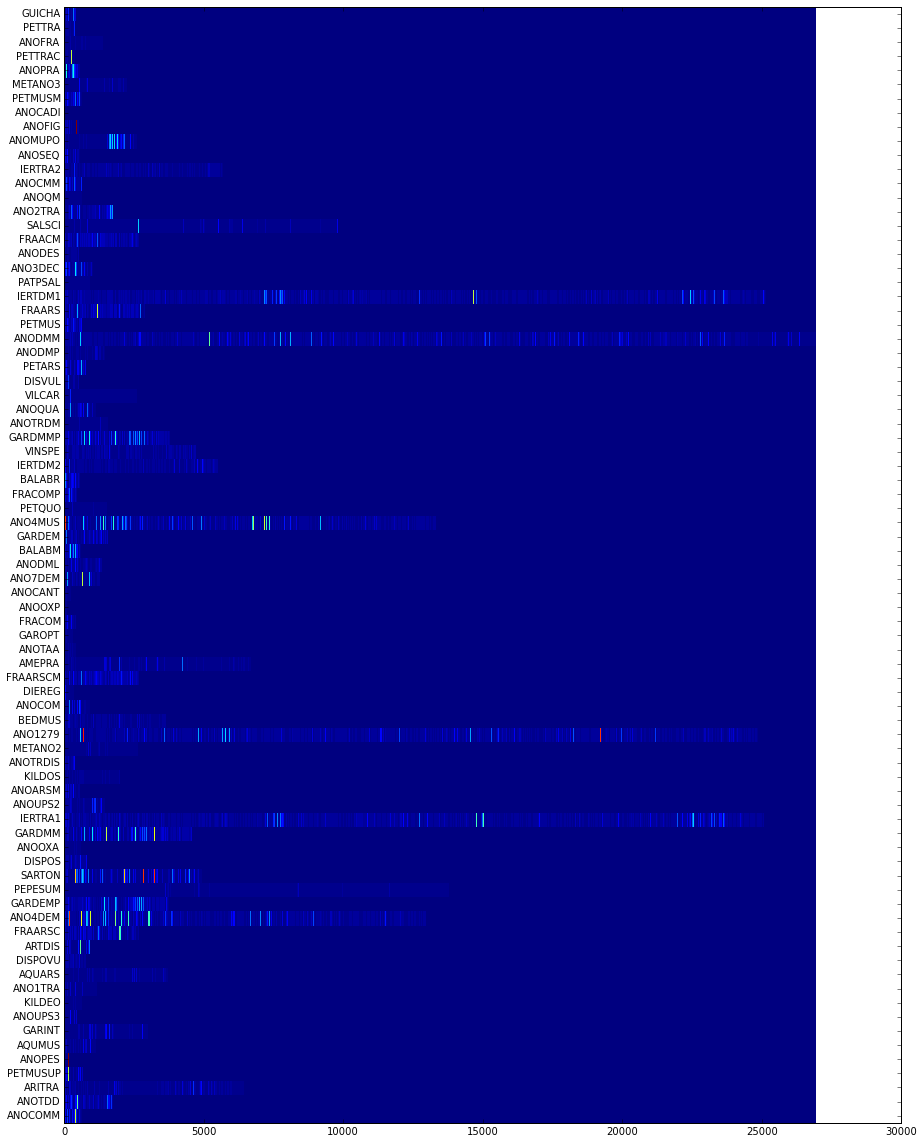

In [47]:
plot_heatmap()